# Reconocimiento Facial con Machine Learning para Seguridad

En este proyecto se desarrolla un sistema de **reconocimiento facial** basado en modelos de *machine learning*, cuyo objetivo es identificar **personas autorizadas** en un entorno de seguridad utilizando **c√°maras de videovigilancia** que capturan im√°genes en tiempo real.

El sistema esta pensado para procesar cada frame capturado por las c√°maras y mediante un algoritmo de **clasificaci√≥n de rostros**, determinando si la persona detectada pertenece al grupo de individuos autorizados o no.

Adicionalmente, se busca extender el an√°lisis para **identificar el g√©nero** de la persona, enriqueciendo as√≠ la informaci√≥n registrada por el sistema. Esta caracter√≠stica puede utilizarse como:
- Capa adicional de validaci√≥n de identidad,
- Generaci√≥n de estad√≠sticas de acceso,
- O implementaci√≥n de pol√≠ticas espec√≠ficas basadas en demograf√≠a.

## Objetivo

- Desarrollar un sistema de **identificaci√≥n facial autom√°tica** para controlar el acceso a zonas seguras.
- Clasificar los rostros capturados no solo por identidad, sino tambi√©n por **g√©nero**.
- Crear un pipeline replicable que pueda escalarse o adaptarse a otros sistemas de videovigilancia.

## Alcance del Proyecto

- Entrenamiento de modelos de reconocimiento facial supervisado.
- Evaluaci√≥n de m√©tricas de desempe√±o (accuracy, precision, recall).

## Uso Comercial

Este tipo de tecnolog√≠a es actualmente utilizada en el mercado por empresas como:
- **Verisure**: Sistemas de alarma con reconocimiento facial para control de acceso y activaci√≥n autom√°tica.
- **ADT**: Soluciones de videovigilancia avanzada que incorporan tecnolog√≠as de identificaci√≥n de personas.

## Dataset Utilizado: Labeled Faces in the Wild (LFW)

Para entrenar el modelo se utilizar√° el *dataset* **Labeled Faces in the Wild (LFW)**, una base de datos ampliamente utilizada para el estudio de t√©cnicas de reconocimiento facial en condiciones reales (*in the wild*).

Caracter√≠sticas principales del *dataset*:

- **N√∫mero total de im√°genes**: 13,233 rostros.
- **N√∫mero de personas**: 5,749 individuos √∫nicos.
- **Personas con 2 o m√°s im√°genes**: 1,680 personas.
- **Tama√±o original de las im√°genes**: 250 √ó 250 p√≠xeles (ajustable).
- **Fuente de im√°genes**: Fotograf√≠as reales recolectadas de internet.
- **Detecci√≥n de rostros**: Utiliza el detector de Viola-Jones para centrar las caras.
- **Etiquetas**: Cada imagen est√° etiquetada con el nombre de la persona correspondiente.

> **Nota**: El *dataset* **no incluye informaci√≥n de g√©nero**; esta deber√° ser a√±adida manualmente si se desea realizar una clasificaci√≥n de g√©nero.

### Acceso al Dataset

El *dataset* puede ser accedido de dos maneras:

1. Desde `scikit-learn` (recomendado para prototipos)

    ```python
    from sklearn.datasets import fetch_lfw_people
    lfw_people = fetch_lfw_people()
    ```
    Esto descarga y organiza autom√°ticamente las im√°genes en un formato adecuado para modelos de machine learning.

2. Desde Kaggle

    Se puede descargar la versi√≥n completa del *dataset* desde el siguiente enlace:

    üëâ [Dataset LFW en Kaggle](https://www.kaggle.com/datasets/jessicali9530/lfw-dataset)

    Esta versi√≥n organiza las im√°genes en carpetas por nombre de persona, lo que facilita su uso para arquitecturas m√°s complejas como **redes neuronales convolucionales (CNNs)**.

### Basado en ejemplo oficial

Este proyecto se inspira en el ejemplo de reconocimiento facial disponible en la documentaci√≥n de **scikit-learn**:

üëâ [Face recognition example (Scikit-learn)](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html)

Con mejoras, adaptaciones y extensi√≥n hacia la **clasificaci√≥n de g√©nero** y aplicaci√≥n en **contextos reales de seguridad**.

Para este trabajo se tomar√°n los datos extraidos directamente desde la librer√≠a, ya que vienen preparados para su uso.

In [27]:
# Importaci√≥n de librer√≠as a utilizar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import wikipedia as wiki
import statistics as stats
import os
import time
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from collections import Counter

In [2]:
# Cargar el dataset (personas con al menos 70 im√°genes para mantener equilibrio en las clases)
lfw_people = fetch_lfw_people()

## EDA: Exploratory Data Analysis

El primer paso a llevar a cabo es explorar los datos provenientes del *dataset* para determinar qu√© tipo de informaci√≥n posee. Dado que el *dataset* est√° pensado para entrenar modelos de clasificaci√≥n o *clustering*, no posee algunos de los m√©todos m√°s comunes de analisis preliminar de datos, tales como `head()`, `info()` o `describe()`.

Por lo tanto, estaremos tomando la [documentaci√≥n oficial](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html) de `fetch_lfw_people` de scikit-learn como referencia. La misma describe el *dataset*, los datos que posee y el formato de los mismos.

### Descripci√≥n del Dataset

El *dataset* **Labeled Faces in the Wild (LFW)** es una colecci√≥n de im√°genes de rostros dise√±ada para el estudio del reconocimiento facial en condiciones no controladas. Cuando se carga utilizando `fetch_lfw_people`, el *dataset* es devuelto como un objeto tipo **Bunch**, similar a un diccionario, que contiene los siguientes atributos:

| Atributo | Forma | Descripci√≥n |
|:---------|:------|:------------|
| **`data`** | `(13233, 2914)` | Matriz donde cada fila representa una imagen de rostro aplanada (flattened). Cada imagen original es de tama√±o `62 √ó 47` p√≠xeles. Cambiar `resize` o `slice_` afecta esta dimensi√≥n. |
| **`images`** | `(13233, 62, 47)` | Array de im√°genes originales. Cada entrada corresponde a un rostro asociado a una de las 5749 personas del *dataset*. |
| **`target`** | `(13233,)` | Array de etiquetas asociadas a cada imagen. Los valores de `target` son enteros en el rango `[0, 5748]`, representando el ID de cada persona. |
| **`target_names`** | `(5749,)` | Array de strings con los nombres de todas las personas en el *dataset*. La posici√≥n en este array corresponde al ID utilizado en `target`. |
| **`DESCR`** | `str` | Descripci√≥n completa del *dataset* LFW. |

### Salida alternativa (`return_X_y=True`)

Si se establece `return_X_y=True` al cargar el *dataset*, se devuelve una **tupla** `(data, target)`:

- **`data`**: Matriz 2D de tama√±o `(n_samples, n_features)`, donde cada fila representa una muestra (imagen aplanada).
- **`target`**: Array de tama√±o `(n_samples,)`, conteniendo las etiquetas asociadas a cada imagen.

### Exploraci√≥n del Formato

Para verificar el formato de los datos, se tomar√° el *dataset* ya descargado y se extraer√°n los principales sets de datos, guardandolos en variables dentro del *script*.

In [3]:
# Extraer las dimensiones principales del dataset:
# - n_samples: cantidad total de im√°genes disponibles
# - h, w: altura y ancho de cada imagen en p√≠xeles
n_samples, h, w = lfw_people.images.shape

# Obtener la matriz de datos:
# Cada fila de X representa una imagen aplanada en un vector de caracter√≠sticas
X = lfw_people.data      

# Obtener las etiquetas:
# Cada elemento de y es un √≠ndice num√©rico que representa a una persona
y = lfw_people.target    

# Obtener los nombres de las personas:
# target_names es un arreglo que contiene el nombre real asociado a cada √≠ndice
target_names = lfw_people.target_names

# Calcular el n√∫mero de clases √∫nicas (personas distintas) en el dataset
n_classes = target_names.shape[0]

# Mostrar informaci√≥n b√°sica sobre el dataset
print(f"N√∫mero de im√°genes: {n_samples}")
print(f"Dimensiones de cada imagen: {h} x {w}")
print(f"N√∫mero de clases (personas): {n_classes}")
print(f"Personas en el dataset: {target_names}")

N√∫mero de im√°genes: 13233
Dimensiones de cada imagen: 62 x 47
N√∫mero de clases (personas): 5749
Personas en el dataset: ['AJ Cook' 'AJ Lamas' 'Aaron Eckhart' ... 'Zumrati Juma' 'Zurab Tsereteli'
 'Zydrunas Ilgauskas']


Para entender un poco mejor el *dataset*, vamos a imprimir algunas de las imagenes junto con el nombre del rotro que se encuentra en la misma.

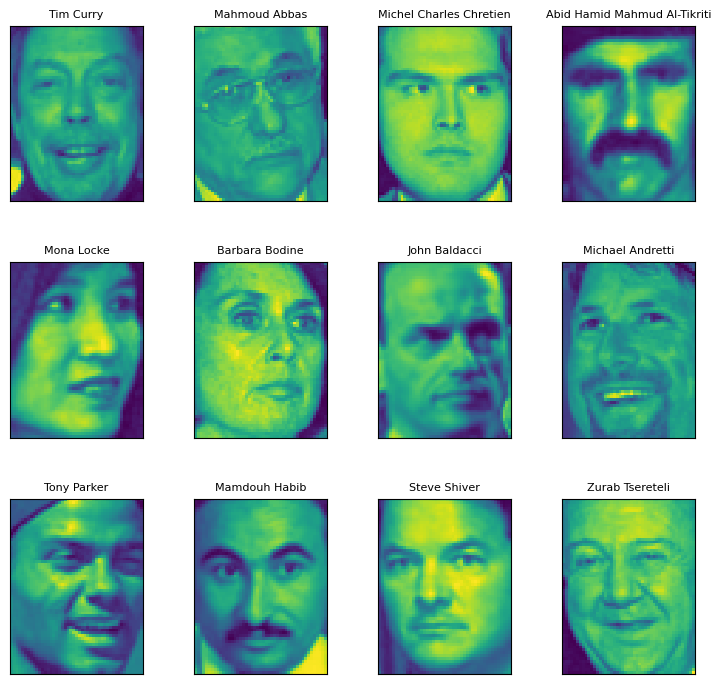

In [4]:
# Funci√≥n para visualizar una galer√≠a de im√°genes
# images: conjunto de im√°genes a mostrar
# titles: t√≠tulos asociados a cada imagen (nombre de la persona)
# h, w: dimensiones (altura, ancho) de cada imagen
# n_row, n_col: cantidad de filas y columnas en la grilla de visualizaci√≥n
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))  # Definir tama√±o de la figura
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)  # Espaciado entre im√°genes
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)  # Crear cada subgr√°fico
        plt.imshow(images[i], interpolation='nearest')  # Mostrar imagen
        plt.title(titles[i], size=8)  # Mostrar t√≠tulo (nombre reducido)
        plt.xticks(())  # Quitar marcas de eje x
        plt.yticks(())  # Quitar marcas de eje y

# Generar t√≠tulos con los nombres de las personas
titles = [target_names[y[i]] for i in range(12)]

# Llamar a la funci√≥n para mostrar las primeras 12 im√°genes
plot_gallery(lfw_people.images, titles, h, w)

# Mostrar la galer√≠a de im√°genes
plt.show()

Algo importante a notar, es que el *dataset* est√° armado como si fuera una base de datos relacional. Es decir, cada imagen posee un *label* num√©rico que se corresponde al ID del nombre de una persona dentro del *dataset*. Esto se debe a que si bien hay 13233 im√°genes, s√≥lo son 5749 personas, por lo que sus IDs van a estar repetidos m√°s de una vez dentro del conjunto de datos **`y`**. Dentro del conjunto de datos **`target_names`** tenemos la relaci√≥n entre cada ID y su respectivo nombre.

### Agregado de datos usando la API de Wikipedia

Para cumplir con el objetivo de clasificar a las personas por genero, se deben generar los labels de g√©nero de cada una de estas personas y asociarlas a cada una de sus im√°genes.

Con este fin, inicialmente se tomar√° el conjunto de datos **`target_names`** y se lo convertir√° a formato **dataframe**. Se guardar√°n los datos en formato **CSV** para revisar los mismos de manera manual.

In [5]:
# Crear un DataFrame solo con los nombres √∫nicos
target_names_df = pd.DataFrame({
    'Label_ID': range(len(target_names)),  # ID num√©rico (posici√≥n en el array)
    'Label_Name': target_names             # Nombre de la persona
})

# Guardar el DataFrame en un archivo CSV
target_names_df.to_csv('lfw_target_names.csv', index=False)

print("Archivo 'lfw_target_names.csv' creado exitosamente.")

Archivo 'lfw_target_names.csv' creado exitosamente.


El siguiente paso ser√° utilizar la API de Wikipedia para determinar los g√©neros de cada una de las personas en el *dataset*.
Dado que cada persona en el *dataset* es una personalidad conocida, se asume que posee una p√°gina de Wikipedia propia.

Wikipedia posee una API propia que es una interfaz que permite consultar informaci√≥n de Wikipedia de forma autom√°tica, sin necesidad de abrir el navegador manualmente. Funciona mediante peticiones HTTP (normalmente `GET` o `POST`) que devuelven los datos en formatos como **JSON** o **XML**. En otras palabras, es como hablar directamente con Wikipedia a trav√©s de c√≥digo, enviando una "pregunta estructurada" y recibiendo una "respuesta organizada" con la informaci√≥n solicitada.

Para poder hacer uso de esta API existe una librer√≠a de Python llamada **`wikipedia`**, que act√∫a como un "cliente" para la API de Wikipedia. Esta librer√≠a permite:

- **Crea autom√°ticamente** las peticiones HTTP correctas.
- **Maneja** errores como ambig√ºedad o p√°ginas no encontradas.
- **Devuelve** la informaci√≥n de Wikipedia en objetos Python f√°ciles de usar (por ejemplo, el t√≠tulo, el contenido o la URL del art√≠culo).

Por ejemplo, con una sola l√≠nea:

```python
page = wikipedia.page('Barack Obama')
```

Se hace internamente toda la conexi√≥n a la API y se recupera el contenido completo de la p√°gina de Barack Obama, listo para ser utilizado en el *script*.

A continuaci√≥n se crea una funci√≥n denominada `detect_gender_with_wikiapi()` que busca un determinado nombre y se encarga de obtener p√°rrafo de la descripci√≥n general de la p√°gina de wikipedia de la persona en cuesti√≥n, y determina si el g√©nero de dicha persona es **Male** o **Female** en base a los pronombres usados. Si se utilizar "*he*" , entonces se asume que la persona es **Male**. Si por el contrario el pronombre para describir a la persona es "*she*", se asume que es **Female**. Si ninguno de los dos pronombres est√° presente, se determina que el g√©nero es **Unknown**.

> **Nota:** Esta funci√≥n puede tomar hasta **145 minutos** para ejecutarse y completar la columna **Gender**.

In [ ]:
# Funci√≥n para detectar el g√©nero leyendo toda la introducci√≥n de la biograf√≠a
def detect_gender_with_wikiapi(name):
    try:
        # Buscar la p√°gina de Wikipedia m√°s relevante para ese nombre
        page = wiki.page(name, auto_suggest=False)

        # Obtener todo el contenido de la p√°gina
        content = page.content

        # Extraer la introducci√≥n: tomamos todo hasta la primera secci√≥n importante
        intro_end_idx = content.find('\n==')
        if intro_end_idx != -1:
            intro = content[:intro_end_idx]
        else:
            intro = content  # Si no hay secciones, usamos todo el contenido

        intro_lower = intro.lower()

        # Detectar g√©nero buscando pronombres en la introducci√≥n
        if ' he ' in intro_lower:
            return 'Male'
        elif ' she ' in intro_lower:
            return 'Female'
        else:
            return 'Unknown'
    except Exception as e:
        # Si ocurre un error (p√°gina no encontrada, ambig√ºedad, etc.)
        return 'Unknown'

# Cargar o crear el CSV
csv_path = 'lfw_target_names_and_gender.csv'

if os.path.exists(csv_path):
    print("Archivo existente encontrado. Cargando...")
    target_names_df = pd.read_csv(csv_path)
else:
    print("Archivo no encontrado. Creando nuevo...")
    target_names_df = pd.DataFrame({
        'Label_ID': range(len(target_names)),  # Asume que 'target_names' est√° cargado
        'Label_Name': target_names,
        'Gender': ['Unknown'] * len(target_names)
    })
    target_names_df.to_csv(csv_path, index=False)
    print("Archivo creado exitosamente.")

# Detectar g√©nero en nombres faltantes
counter = 0

for idx, row in target_names_df.iterrows():
    if row['Gender'] == 'Unknown':
        name = row['Label_Name']
        gender = detect_gender_with_wikiapi(name)
        target_names_df.at[idx, 'Gender'] = gender
        counter += 1

        # Mostrar progreso
        print(f"[{idx}] {name} ‚Üí {gender}")

        # Cada 100 nombres guardamos avance
        if counter % 100 == 0:
            target_names_df.to_csv(csv_path, index=False)
            print(f"Avance guardado despu√©s de {counter} nombres.")

        # Pausa entre consultas para evitar bloqueo por parte de Wikipedia
        time.sleep(0.75)

# Guardar definitivamente el archivo
target_names_df.to_csv(csv_path, index=False)
print("Archivo final actualizado y guardado correctamente.")

Una vez que ejecutada la funci√≥n debemos verificar la efectividad de la misma, por lo que se imprimir√°n las cantidades obtenidas en cada caso.

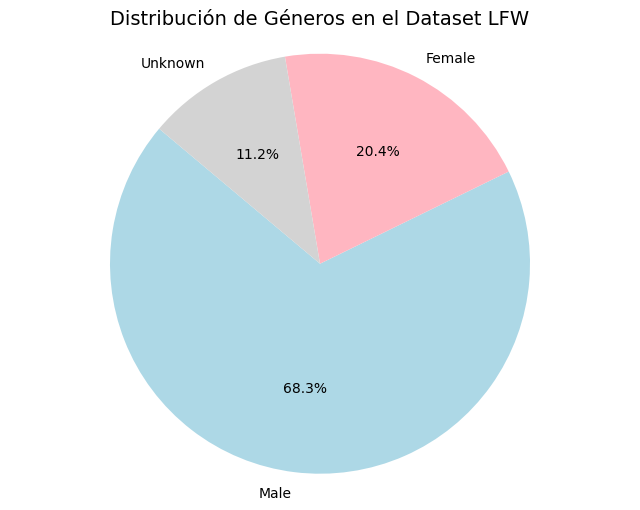

In [6]:
# Cargar el archivo CSV con los nombres y g√©neros
df = pd.read_csv('lfw_target_names_and_gender.csv')

# Contar la cantidad de ocurrencias de cada g√©nero
gender_counts = df['Gender'].value_counts()

# Definir los colores seg√∫n el g√©nero
color_mapping = {
    'Male': 'lightblue',
    'Female': 'lightpink',
    'Unknown': 'lightgray'
}

# Obtener los colores en el orden correcto seg√∫n los labels
colors = [color_mapping[gender] for gender in gender_counts.index]

# Crear un gr√°fico de torta para visualizar la distribuci√≥n de g√©neros
plt.figure(figsize=(8, 6))
plt.pie(
    gender_counts,
    labels=gender_counts.index,
    autopct='%1.1f%%',         # Mostrar el porcentaje en cada secci√≥n
    startangle=140,            # Rotar el gr√°fico para mejor orientaci√≥n
    colors=colors              # Aplicar los colores personalizados
)

plt.title('Distribuci√≥n de G√©neros en el Dataset LFW', fontsize=14)
plt.axis('equal')  # Mantener proporci√≥n de c√≠rculo
plt.show()

La funci√≥n fue capaz de detectar al 47% de los nombres como g√©nero masculino, pero s√≥lo a un 15% como g√©nero femenino, de manera tal que el segundo grupo m√°s grande son los no identificados con el 37%. Si bien la efectividad no fue muy alta, nos permite avanzar con un segundo proceso para tratar de determinar el g√©nero de la mayor cantidad de nombres posibles.

Dado que la cantidad de personas en en el *dataset* es tan grande, muchos nombres de pila se repiten, de esta manera tenemos m√°s de un "James", por ejemplo. Si al menos una persona con ese nombre ha sido identificada como de g√©nero masculino, podemos considerar que las dem√°s llamadas "James" tambi√©n son del mismo g√©nero. Con esta premisa se construye la funci√≥n `infer_gender_by_first_name()`, la cual:
- Carga el CSV existente con la columna Gender.
- Extrae el primer nombre (nombre de pila) de cada persona.
- Construye un diccionario de referencia a partir de los nombres ya clasificados (Male o Female).
- Recorre nuevamente todos los registros con g√©nero Unknown, y si su primer nombre aparece en el diccionario, les asigna el mismo g√©nero.
- Guarda el nuevo CSV actualizado.

In [7]:
def infer_gender_by_first_name(csv_path):
    # Cargar el archivo CSV
    df = pd.read_csv(csv_path)

    # Asegurarse de que la columna 'Gender' exista
    if 'Gender' not in df.columns or 'Label_Name' not in df.columns:
        raise ValueError("El CSV debe contener las columnas 'Label_Name' y 'Gender'.")

    # Extraer el primer nombre (nombre de pila)
    df['First_Name'] = df['Label_Name'].apply(lambda x: x.split()[0] if isinstance(x, str) else '')

    # Crear diccionario: primer nombre ‚Üí g√©nero m√°s frecuente (entre los que ya tienen g√©nero asignado)
    known_genders = df[df['Gender'].isin(['Male', 'Female'])]
    name_gender_map = known_genders.groupby('First_Name')['Gender'].agg(lambda x: x.value_counts().idxmax()).to_dict()

    # Reasignar g√©nero a los Unknown si su primer nombre aparece en el diccionario
    updated_count = 0
    for i, row in df[df['Gender'] == 'Unknown'].iterrows():
        first_name = row['First_Name']
        if first_name in name_gender_map:
            df.at[i, 'Gender'] = name_gender_map[first_name]
            updated_count += 1

    # Guardar archivo actualizado
    df.drop(columns='First_Name', inplace=True)
    df.to_csv(csv_path, index=False)

    print(f"Actualizaci√≥n completada. {updated_count} g√©neros fueron inferidos por nombre de pila.")

# Ejecutar
infer_gender_by_first_name('lfw_target_names_and_gender.csv')


Actualizaci√≥n completada. 0 g√©neros fueron inferidos por nombre de pila.


Luego de correr la funci√≥n `infer_gender_by_first_name()` se consigue determinar el g√©nero de 1510 nombre adicionales. Volvemos entonces a determinar los porcentajes de cada g√©nero en el archivo **CSV** generado.

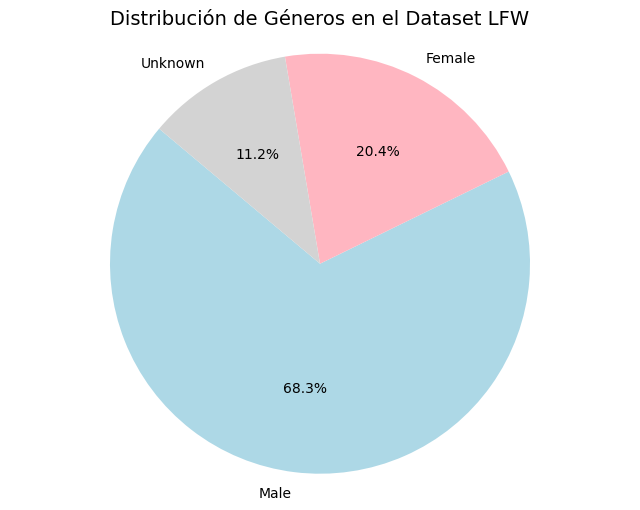

In [8]:
# Cargar el archivo CSV con los nombres y g√©neros
df = pd.read_csv('lfw_target_names_and_gender.csv')

# Contar la cantidad de ocurrencias de cada g√©nero
gender_counts = df['Gender'].value_counts()

# Definir los colores seg√∫n el g√©nero
color_mapping = {
    'Male': 'lightblue',
    'Female': 'lightpink',
    'Unknown': 'lightgray'
}

# Obtener los colores en el orden correcto seg√∫n los labels
colors = [color_mapping[gender] for gender in gender_counts.index]

# Crear un gr√°fico de torta para visualizar la distribuci√≥n de g√©neros
plt.figure(figsize=(8, 6))
plt.pie(
    gender_counts,
    labels=gender_counts.index,
    autopct='%1.1f%%',         # Mostrar el porcentaje en cada secci√≥n
    startangle=140,            # Rotar el gr√°fico para mejor orientaci√≥n
    colors=colors              # Aplicar los colores personalizados
)

plt.title('Distribuci√≥n de G√©neros en el Dataset LFW', fontsize=14)
plt.axis('equal')  # Mantener proporci√≥n de c√≠rculo
plt.show()

En este caso solo el 11.2% de los nombres se mantienen con un g√©nero desconocido, pero los conocidos suman el 88.7%, por lo que concluimos que las *labels* generadas son suficientes para entrenar un modelo de clasificaci√≥n que permita distinguir entre g√©neros basados en las im√°genes de esas personas.

Tambi√©n es importante notar que el *dataset* posee una desproporci√≥n muy grande entre los rostros de varones y mujeres. Aproximadamente solo 1 de cada 5 nombres pertenece a una mujer. En consecuencia se puede inferir que el *dataset* de im√°genes posee m√°s im√°genes de hombres que de mujeres, por lo que para entrenar un clasificador por g√©nero se deber√° tomar dos posibles caminos:
- Se entrena un clasificador que detecte varones, y todo lo que no sea un var√≥n sea considerado mujer.
- Se entrena un clasificador de doble salida, donde se identifican hombres y mujeres, pero para ello el *dataset* de entrenamiento deber√° estar balanceado para que posea una cantidad id√©ntica de instancias de ambos g√©neros.

### Cantidad de Im√°genes por Individuo

A continuaci√≥n se determinar√° cuantas im√°genes de cada persona hay en el dataframe. Esto puede ser determinado a partir de los datos de los *labels* guardados en **y**. Cada valor de **y** se corresponde con el *label* (nombre) de una persona, por lo que si se cuentan la cantidad de veces que cada n√∫mero se repite, se determina la cantidad de im√°genes que existen en el *dataset* de una persona en particular.

Antes de llevar a cabo este paso, se guardan los datos en un archivo en formato CSV, con el fin de poder acceder a los mismos de forma independiente y sin la necesidad de descargar el *dataset*.

In [9]:
# Convertir 'y' a DataFrame
y_df = pd.DataFrame(y, columns=['Label_ID'])

# Guardar el DataFrame como archivo CSV
y_df.to_csv('lfw_targets.csv', index=False)

print("Archivo 'lfw_targets.csv' guardado exitosamente.")

Archivo 'lfw_targets.csv' guardado exitosamente.


El siguiente paso crear un gr√°fico de barras con la informaci√≥n de la cantidad de im√°genes por persona.

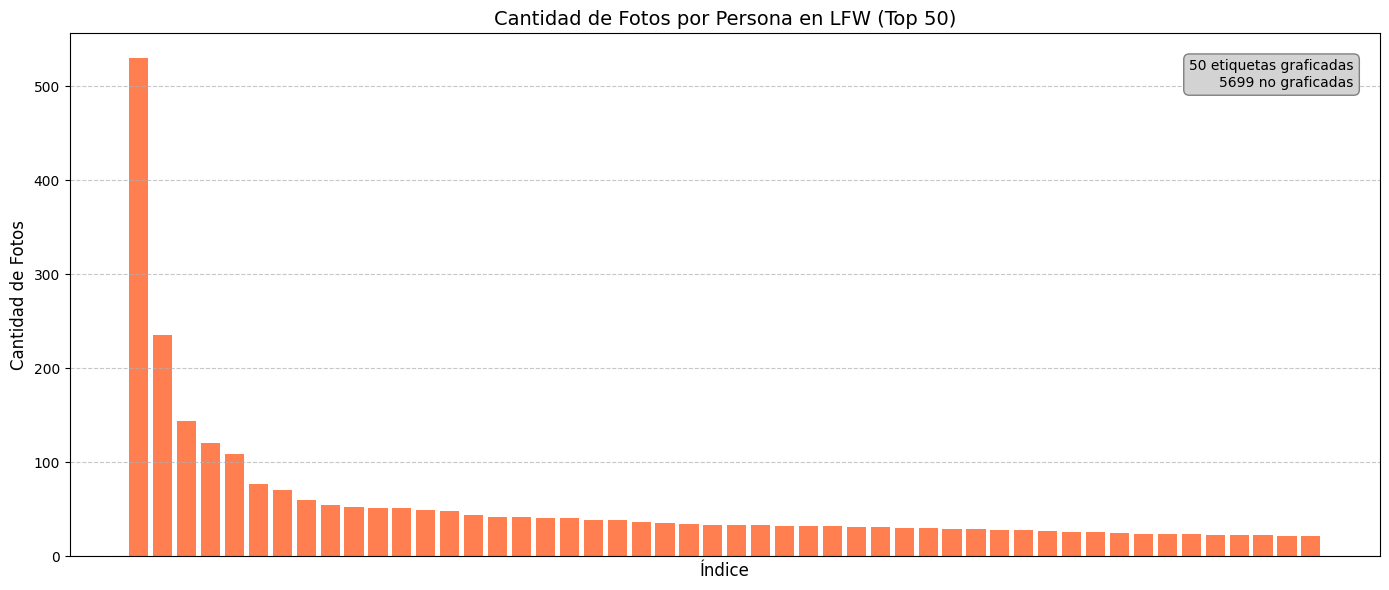

In [10]:
# Cargar el CSV que contiene los IDs de los targets
y_df = pd.read_csv('lfw_targets.csv')

# Contar cu√°ntas veces aparece cada Label_ID
label_counts = Counter(y_df['Label_ID'])

# Crear un DataFrame con los resultados
photo_count_df = pd.DataFrame({
    'Label_ID': list(label_counts.keys()),
    'Photo_Count': list(label_counts.values())
})

# Ordenar por cantidad de fotos (de mayor a menor)
photo_count_df = photo_count_df.sort_values(by='Photo_Count', ascending=False).reset_index(drop=True)

# Limitar a los primeros 50
max_labels = 50
filtered_df = photo_count_df.head(max_labels)

# C√°lculo de m√©tricas para mostrar
plotted_count = len(filtered_df)
excluded_count = len(photo_count_df) - plotted_count

# Graficar
plt.figure(figsize=(14, 6))
plt.bar(filtered_df.index, filtered_df['Photo_Count'], color='coral')

plt.xlabel('√çndice', fontsize=12)
plt.ylabel('Cantidad de Fotos', fontsize=12)
plt.title('Cantidad de Fotos por Persona en LFW (Top 50)', fontsize=14)

# Agregar recuadro informativo dentro del gr√°fico
info_text = f'{plotted_count} etiquetas graficadas\n{excluded_count} no graficadas'
plt.gca().text(
    0.98, 0.95, info_text,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round,pad=0.4', facecolor='lightgray', edgecolor='gray')
)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks([])  # Eliminar etiquetas del eje X
plt.tight_layout()
plt.show()

Este gr√°fico muestra los *labels* del *dataset* (es decir, el √≠ndice del nombre de cada persona) de mayor a menor, graficando las cantidades de los primeros 50. Como se observa, el m√≠nimo est√° en 22 fotos, por lo que las 5699 personas que est√°n en el *dataset* poseen 22 im√°genes o menos.

Considerando los valores obtenidos, se calculan algunas m√©tricas auxiliares: m√°ximo, m√≠nimo, media, moda, mediana y cuartiles. Adem√°s, se buscar√°n las 10 personas con mayor cantidad de fotos. Estas ser√°n las personas para las cuales entrenaremos el clasificador que busca determinar personal autorizado de personal no autorizado.

In [11]:
# Unir para agregar los nombres
photo_count_df = photo_count_df.merge(target_names_df, on='Label_ID')

# Mostrar Top 10 personas m√°s fotografiadas
top_10 = photo_count_df.sort_values(by='Photo_Count', ascending=False).head(10)

print("\nTop 10 personas con m√°s im√°genes:")
print(top_10[['Label_Name', 'Photo_Count']])

# Calcular estad√≠sticas
photo_counts_list = photo_count_df['Photo_Count'].tolist()

mean_photos = sum(photo_counts_list) / len(photo_counts_list)
median_photos = stats.median(photo_counts_list)
mode_photos = stats.mode(photo_counts_list)
min_photos = min(photo_counts_list)
max_photos = max(photo_counts_list)

# Calcular cuartiles
quartiles = np.percentile(photo_counts_list, [25, 50, 75])

print("\nEstad√≠sticas de cantidad de fotos por persona:")
print(f"Media (promedio): {mean_photos:.2f}")
print(f"Mediana: {median_photos}")
print(f"Moda: {mode_photos}")
print(f"M√≠nimo: {min_photos}")
print(f"M√°ximo: {max_photos}")
print(f"Primer cuartil (Q1, 25%): {quartiles[0]}")
print(f"Segundo cuartil (Q2, 50% - Mediana): {quartiles[1]}")
print(f"Tercer cuartil (Q3, 75%): {quartiles[2]}")



Top 10 personas con m√°s im√°genes:
          Label_Name  Photo_Count
0      George W Bush          530
1       Colin Powell          236
2         Tony Blair          144
3    Donald Rumsfeld          121
4  Gerhard Schroeder          109
5       Ariel Sharon           77
6        Hugo Chavez           71
7  Junichiro Koizumi           60
8      Jean Chretien           55
9      John Ashcroft           53

Estad√≠sticas de cantidad de fotos por persona:
Media (promedio): 2.30
Mediana: 1
Moda: 1
M√≠nimo: 1
M√°ximo: 530
Primer cuartil (Q1, 25%): 1.0
Segundo cuartil (Q2, 50% - Mediana): 1.0
Tercer cuartil (Q3, 75%): 2.0


Al generar las estad√≠sticas del *dataset* encontramos que la mayor√≠a de las personas posee s√≥lo una foto y que el promedio de hecho se encuntra influenciado por el m√°ximo de 530. Esto implica que s√≥lo las primeras 10 personas que poseen suficientes fotos podr√≠an ser consideradas dentro del *dataset* de entrenamiento para ser identificadas por el modelo. Las dem√°s no poseen suficientes instancias como para entrenar un clasificador y que el mismo lleve a cabo la selecci√≥n correctamente.

Aprovechando la funci√≥n `plot_gallery()` creada previamente, se imprimen las im√°genes de las 10 personas con mayor cantidad de im√°genes en el *dataset*.

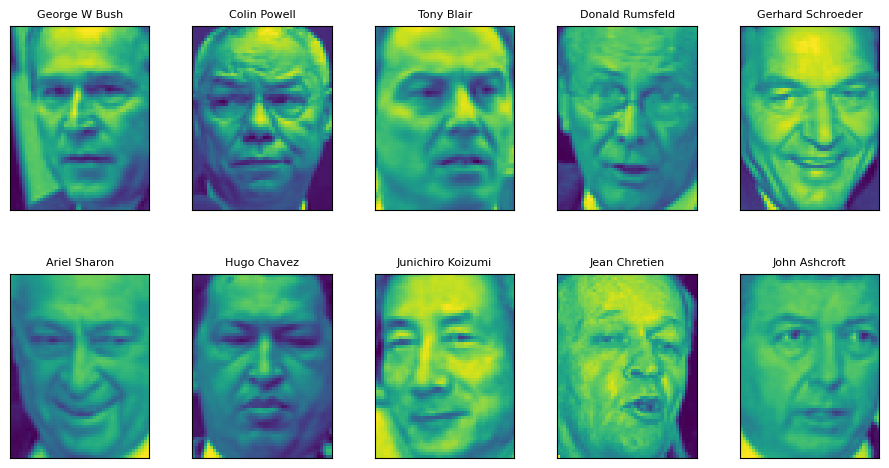

In [12]:
# Obtener las Label_IDs de las 10 personas m√°s populares
top_10_label_ids = top_10['Label_ID'].tolist()

# Filtrar im√°genes correspondientes a esas personas
selected_images = []
selected_titles = []

# Limitar cantidad de im√°genes para visualizaci√≥n (ej: 1 por persona)
for label_id in top_10_label_ids:
    indices = (lfw_people.target == label_id).nonzero()[0]
    if len(indices) > 0:
        selected_images.append(lfw_people.images[indices[0]])  # Tomar la primera imagen
        selected_titles.append(target_names_df.loc[target_names_df['Label_ID'] == label_id, 'Label_Name'].values[0])

# Mostrar galer√≠a
plot_gallery(selected_images, selected_titles, lfw_people.images.shape[1], lfw_people.images.shape[2],
             n_row=2, n_col=5)
plt.show()

## Reconocimiento de Personas Autorizadas

### Preparaci√≥n de los Datos

Habiendo analizado el *dataset*, el siguiente paso a llevar a cabo es separar los datos para generar un *train set* y un *test set*. Dado que estamos interesados en entrenar algoritmos de clasificaci√≥n para detectar a las 10 personas con mayor cantidad de imagenes en el *dataset*, es necesario primero separar las im√°genes de estas personas de forma proporcional en ambos conjuntos (*train* y *test set*), y luego sumar cada sub *dataset* al resto de las im√°genes tambi√©n separadas en los sub *datasets* ya mensionados.

In [13]:
# Crear una m√°scara para identificar las im√°genes que pertenecen a las 10 personas m√°s fotografiadas
mask_top10 = np.isin(y, top_10_label_ids)

# Obtener los √≠ndices de las im√°genes que corresponden al top 10 y al resto de personas
indices_top10 = np.where(mask_top10)[0]
indices_rest = np.where(~mask_top10)[0]

# Extraer las im√°genes (X) y sus etiquetas (y) del top 10
X_top10 = X[indices_top10]
y_top10 = y[indices_top10]

# Dividir las im√°genes del top 10 en conjuntos de entrenamiento y prueba,
# manteniendo proporciones similares de im√°genes por persona (estratificaci√≥n)
X_train_top10, X_test_top10, y_train_top10, y_test_top10, idx_train_top10, idx_test_top10 = train_test_split(
    X_top10,
    y_top10,
    indices_top10,
    test_size=0.2,
    stratify=y_top10,
    random_state=42
)

# Extraer las im√°genes del resto de las personas
X_rest = X[indices_rest]
y_rest = y[indices_rest]

# Dividir las im√°genes del resto de las personas en entrenamiento y prueba de forma aleatoria
X_train_rest, X_test_rest, y_train_rest, y_test_rest = train_test_split(
    X_rest,
    y_rest,
    test_size=0.2,
    random_state=42
)

# Unir las divisiones del top 10 y del resto para obtener los datasets finales
X_train = np.concatenate([X_train_top10, X_train_rest])
y_train = np.concatenate([y_train_top10, y_train_rest])

X_test = np.concatenate([X_test_top10, X_test_rest])
y_test = np.concatenate([y_test_top10, y_test_rest])

# Mostrar estad√≠sticas b√°sicas para verificar que se mantiene la proporci√≥n de las 10 personas
print("Total de im√°genes de entrenamiento:", len(X_train))
print("Total de im√°genes de prueba:", len(X_test))

Total de im√°genes de entrenamiento: 10585
Total de im√°genes de prueba: 2648


De esta manera se puede determinar qu√© cantidad de im√°genes de cada persona quedaron tanto en el *train set* como en el *test set*, junto a sus correspondientes √≠ndices.

In [14]:
# Crear un DataFrame con las cantidades de im√°genes por persona en train y test
train_counts = pd.Series(y_train).value_counts().rename('Train_Count')
test_counts = pd.Series(y_test).value_counts().rename('Test_Count')

# Combinar con los nombres desde target_names_df
summary_df = top_10[['Label_ID', 'Label_Name']].copy()
summary_df = summary_df.merge(train_counts, left_on='Label_ID', right_index=True, how='left')
summary_df = summary_df.merge(test_counts, left_on='Label_ID', right_index=True, how='left')

# Mostrar la tabla
print("\nResumen de im√°genes por persona en los conjuntos de entrenamiento y prueba:")
print(summary_df)


Resumen de im√°genes por persona en los conjuntos de entrenamiento y prueba:
   Label_ID         Label_Name  Train_Count  Test_Count
0      1871      George W Bush          424         106
1      1047       Colin Powell          189          47
2      5458         Tony Blair          115          29
3      1404    Donald Rumsfeld           97          24
4      1892  Gerhard Schroeder           87          22
5       373       Ariel Sharon           61          16
6      2175        Hugo Chavez           57          14
7      2941  Junichiro Koizumi           48          12
8      2453      Jean Chretien           44          11
9      2682      John Ashcroft           42          11


### Clasificador Binario

Ahora que hemos separado el *dataset* en *train set* y *test set*, procederemos a instaciar un clasificador binario, es decir, es un modelo que determina si una instancia pertenece a una determinada clase o no. En este caso utilizaremos la clase *Stochastic Gradient Decent Classifier* (`SDGClassifier`) de *Scikit-Learn*.

Para evaluar el clasificador, utilizaremos algunas m√©tricas muy utilizadas en este tipo de modelos:

- **Precision (Precisi√≥n)**: La precisi√≥n mide cu√°ntas de las predicciones positivas realizadas por el modelo fueron realmente positivas.

    $\text{Precision} = \frac{TP}{TP + FP}$

- **Recall (Sensibilidad o Exhaustividad)**: El recall mide cu√°ntas de las instancias realmente positivas fueron correctamente detectadas por el modelo.

    $\text{Recall} = \frac{TP}{TP + FN}$

- **F1 Score**: La F1 Score es la media arm√≥nica entre precisi√≥n y recall. Es √∫til cuando queremos un balance entre ambos.

    $F_1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$

> **Nota**: Los valores **TP** son los verdades positivos, los valores **FP** son los falsos positivos y finalmente los **FN** son los falsos negativos.


              precision    recall  f1-score   support

     No Bush       0.98      0.97      0.97      2542
        Bush       0.41      0.57      0.48       106

    accuracy                           0.95      2648
   macro avg       0.70      0.77      0.73      2648
weighted avg       0.96      0.95      0.95      2648



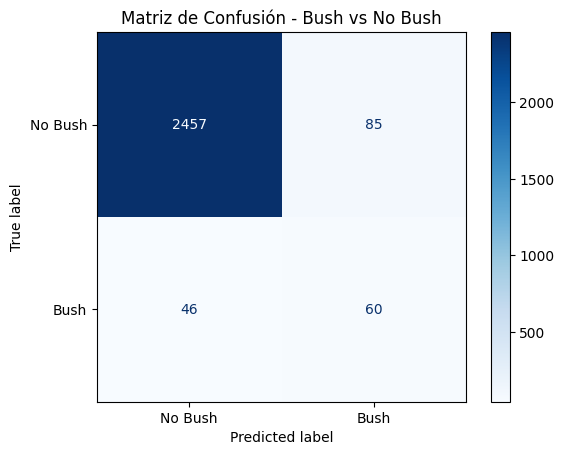

In [25]:
# Seleccionar el label ID de George W. Bush (seg√∫n top_10 se identific√≥ como 1871)
# Creamos un vector binario donde True indica que la imagen pertenece a Bush
y_train_gwb = (y_train == 1871)
y_test_gwb = (y_test == 1871)

# Entrenar un clasificador lineal usando Stochastic Gradient Descent para detectar si una imagen es de Bush o no
sgd_clf_gwb = SGDClassifier(random_state=42)
sgd_clf_gwb.fit(X_train, y_train_gwb)

# Predecir las etiquetas del conjunto de test usando el modelo entrenado
# Esto nos da una predicci√≥n booleana: True si el modelo cree que es Bush, False si no
y_pred = sgd_clf_gwb.predict(X_test)

# Imprimir un informe de clasificaci√≥n que incluye:
# - Precisi√≥n (precision): cu√°ntas predicciones positivas fueron correctas
# - Recall (sensibilidad): cu√°ntos casos positivos fueron detectados
# - F1-score: media arm√≥nica entre precisi√≥n y recall
# - Soporte: cantidad real de ejemplos por clase
# El par√°metro target_names da nombres legibles a las clases: 0 = "No Bush", 1 = "Bush"
print(classification_report(y_test_gwb, y_pred, target_names=["No Bush", "Bush"]))

# Generar la matriz de confusi√≥n, que muestra:
# - Verdaderos negativos (TN): correctamente clasificados como "No Bush"
# - Falsos positivos (FP): incorrectamente clasificados como "Bush"
# - Falsos negativos (FN): casos de Bush que no fueron detectados
# - Verdaderos positivos (TP): correctamente clasificados como "Bush"
cm = confusion_matrix(y_test_gwb, y_pred)

# Visualizar la matriz de confusi√≥n con etiquetas
# Esto ayuda a interpretar el rendimiento del modelo de manera visual
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Bush", "Bush"])
disp.plot(cmap='Blues')  # Se elige un mapa de color azul para mejor visibilidad

# T√≠tulo del gr√°fico
plt.title("Matriz de Confusi√≥n - Bush vs No Bush")
plt.show()

Como se puede observar, el clasificador no posee muy buenos resultados, lo cual se debe a que el *dataset* est√° desbalanceado. Se puede tratar de determinar las curvas de precisi√≥n y recall utilizando la funci√≥n `cross_val_predict()`que en lugar de devolver las predicciones, devuelve los *scores* de decisi√≥n en cada instancia.

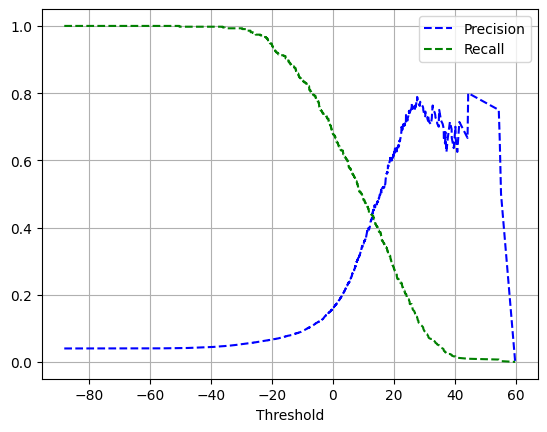

In [28]:
y_scores = cross_val_predict(sgd_clf_gwb, X_train, y_train_gwb, cv=3, method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train_gwb, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="best")
    plt.grid()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()